## Business Problem

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install necessary packages
!pip install rouge_score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f99fd5c706ace1c2f62b66f4078bbe76bba727c02e66b94207b8417421f5ca38
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00


## Imports

In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import unicodedata
from collections import Counter
from transformers import (
    GenerationConfig,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    Trainer,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
    BertModel,
    GPT2LMHeadModel,
    EncoderDecoderModel,
    BertConfig,
    BertTokenizer,
    GPT2Config,
    GPT2Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
    T5Tokenizer,
    T5ForConditionalGeneration,
    PegasusTokenizer,
    PegasusForConditionalGeneration
)
from tqdm import tqdm
import nltk
import torch
from nltk.tokenize import word_tokenize
nltk.download('all')

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

# Load Dataset

In [4]:
# Load samsun dataset
ds = load_dataset("knkarthick/samsum")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

In [5]:
# print dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [6]:
# Split into Pandas DF's for each dataset for preprocessing
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()
val_df = ds["validation"].to_pandas()

# Exploratory Data Analysis

In [7]:
# View top 5 rows
print(train_df.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  


In [8]:
# View Size and shape
print(train_df.size, train_df.shape)

44196 (14732, 3)


In [9]:
# Check for Null Values in DF's
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(val_df.isnull().sum())

id          0
dialogue    1
summary     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64


In [10]:
# View row with Null value
train_df[train_df.isnull().any(axis=1)]

,id,dialogue,summary
6054,13828807,None,problem with visualization of the content


In [11]:
# Drop the row with a Null value
train_df = train_df.dropna()

In [12]:
# Check null counts again in training DF to ensure it is gone
print(train_df.isnull().sum())

id          0
dialogue    0
summary     0
dtype: int64


In [13]:
# Calculate Character length of dialogue and summary in training DF
train_df["dialogue_length"] = train_df["dialogue"].apply(len)
train_df["summary_length"] = train_df["summary"].apply(len)

# Calculate the ratio of how much longer the original dialogue is compared to the summary
train_df["diag_sum_ratio"] = train_df["dialogue_length"] / train_df["summary_length"]


# Test DataFrame
# Calculate Character length of dialogue and summary in training DF
test_df["dialogue_length"] = test_df["dialogue"].apply(len)
test_df["summary_length"] = test_df["summary"].apply(len)

# Calculate the ratio of how much longer the original dialogue is compared to the summary
test_df["diag_sum_ratio"] = test_df["dialogue_length"] / test_df["summary_length"]


# Validation Dataframe
# Calculate Character length of dialogue and summary in training DF
val_df["dialogue_length"] = val_df["dialogue"].apply(len)
val_df["summary_length"] = val_df["summary"].apply(len)

# Calculate the ratio of how much longer the original dialogue is compared to the summary
val_df["diag_sum_ratio"] = val_df["dialogue_length"] / val_df["summary_length"]

In [14]:
# View training DF top 5 rows again
train_df.head()

,id,dialogue,summary,dialogue_length,summary_length,diag_sum_ratio
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...,92,56,1.642857
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,108,61,1.770492
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...,519,77,6.740260
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,152,97,1.567010
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com...",888,145,6.124138


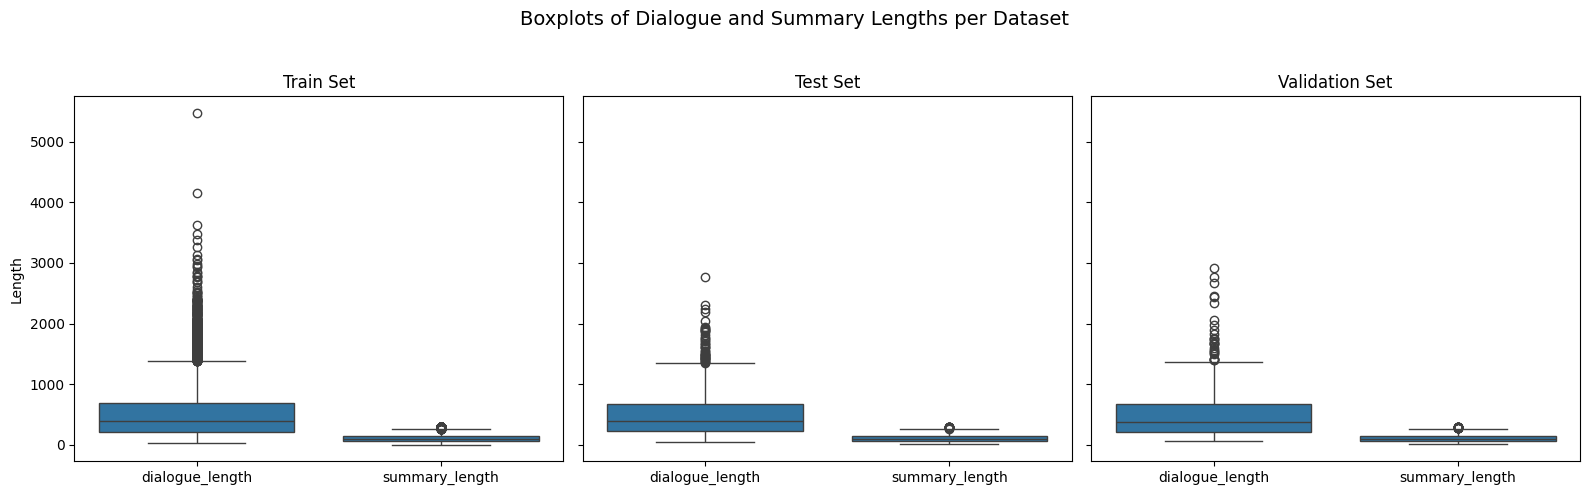

In [15]:
# Create a boxplot to show the character length of the dialogue and summary
train_length_df = train_df.melt(value_vars=["dialogue_length", "summary_length"], var_name="Type", value_name="Length")
test_length_df = test_df.melt(value_vars=["dialogue_length", "summary_length"], var_name="Type", value_name="Length")
val_length_df = val_df.melt(value_vars=["dialogue_length", "summary_length"], var_name="Type", value_name="Length")


# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Plot each dataset in a subplot
sns.boxplot(ax=axes[0], x="Type", y="Length", data=train_length_df)
axes[0].set_title("Train Set")
axes[0].set_xlabel("")
axes[0].set_ylabel("Length")

sns.boxplot(ax=axes[1], x="Type", y="Length", data=test_length_df)
axes[1].set_title("Test Set")
axes[1].set_xlabel("")

sns.boxplot(ax=axes[2], x="Type", y="Length", data=val_length_df)
axes[2].set_title("Validation Set")
axes[2].set_xlabel("")

# Set common x-axis label
fig.suptitle("Boxplots of Dialogue and Summary Lengths per Dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

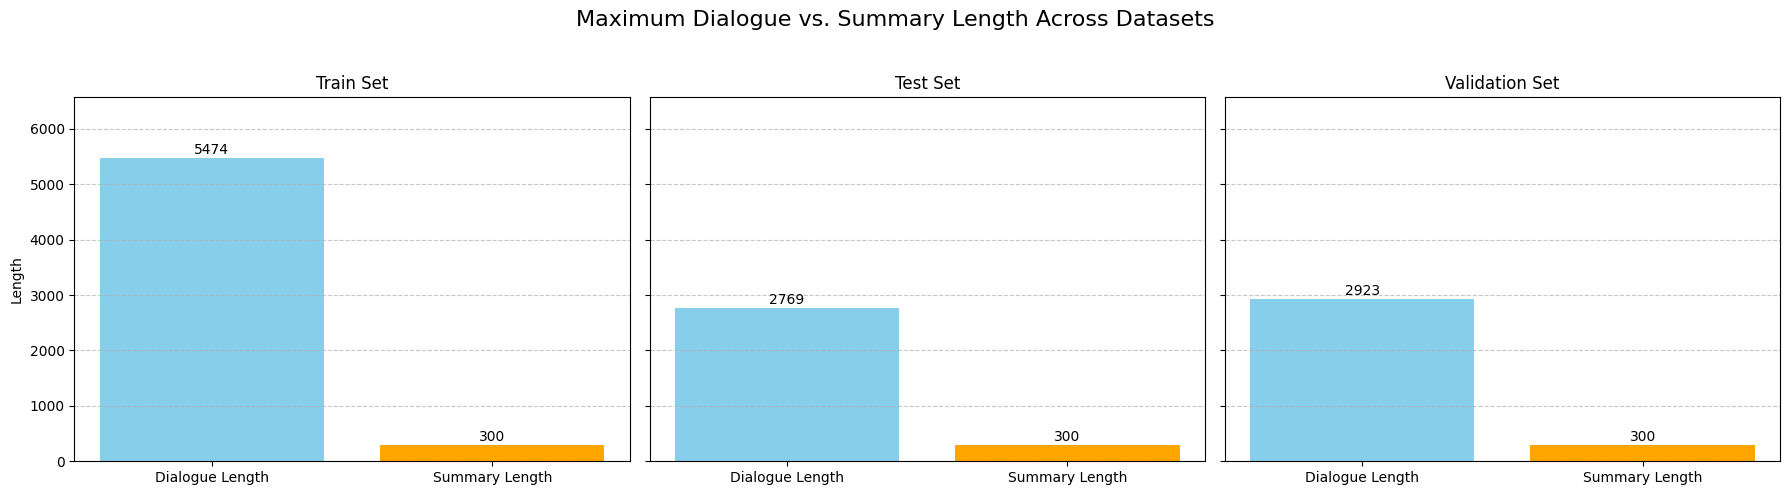

In [16]:
# Calculate max dialogue and summary length

#Create dictionaries for each dataset with max value
max_lengths = {
    "Train": [
        train_df["dialogue_length"].max(),
        train_df["summary_length"].max()
    ],
    "Test": [
        test_df["dialogue_length"].max(),
        test_df["summary_length"].max()
    ],
    "Validation": [
        val_df["dialogue_length"].max(),
        val_df["summary_length"].max()
    ]
}

# Plot labels and values
labels = ["Dialogue Length", "Summary Length"]
colors = ["skyblue", "orange"]


# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (dataset_name, values) in enumerate(max_lengths.items()):
    ax = axes[i]
    bars = ax.bar(labels, values, color=colors)
    ax.set_title(f"{dataset_name} Set")
    ax.set_ylabel("Length" if i == 0 else "")
    ax.set_ylim(0, max(max_lengths["Train"] + max_lengths["Test"] + max_lengths["Validation"]) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 20,
            f"{height:.0f}",
            ha='center', va='bottom', fontsize=10
        )

# Overall title and layout
fig.suptitle("Maximum Dialogue vs. Summary Length Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

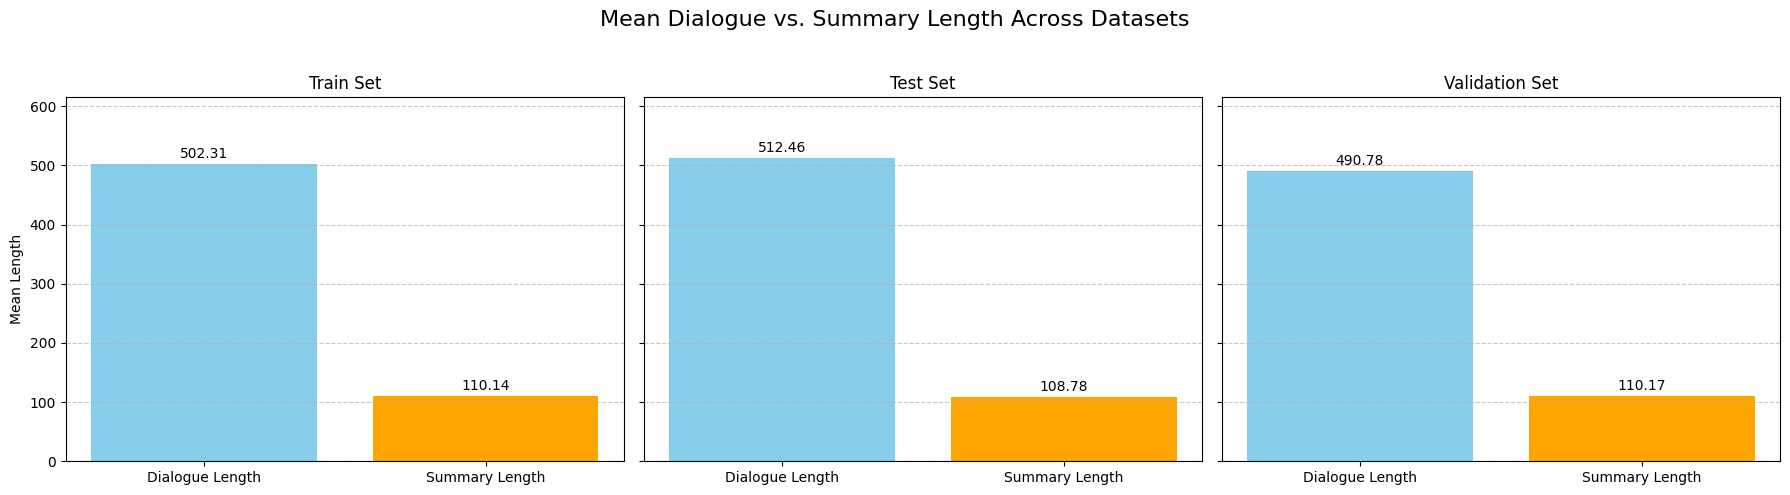

In [17]:
# Calculate average dialogue length and summary length

#Create dictionaries for each dataset with average value
mean_lengths = {
    "Train": [
        train_df["dialogue_length"].mean(),
        train_df["summary_length"].mean()
    ],
    "Test": [
        test_df["dialogue_length"].mean(),
        test_df["summary_length"].mean()
    ],
    "Validation": [
        val_df["dialogue_length"].mean(),
        val_df["summary_length"].mean()
    ]
}

# Labels for plot with values
labels = ["Dialogue Length", "Summary Length"]
colors = ["skyblue", "orange"]

# Plot bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Max y for consistent scaling
max_y = max([max(lengths) for lengths in mean_lengths.values()]) * 1.2

for i, (dataset_name, values) in enumerate(mean_lengths.items()):
    ax = axes[i]
    bars = ax.bar(labels, values, color=colors)
    ax.set_title(f"{dataset_name} Set")
    ax.set_ylabel("Mean Length" if i == 0 else "")
    ax.set_ylim(0, max_y)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 5,
            f"{height:.2f}",
            ha='center', va='bottom', fontsize=10
        )

# Overall layout
fig.suptitle("Mean Dialogue vs. Summary Length Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

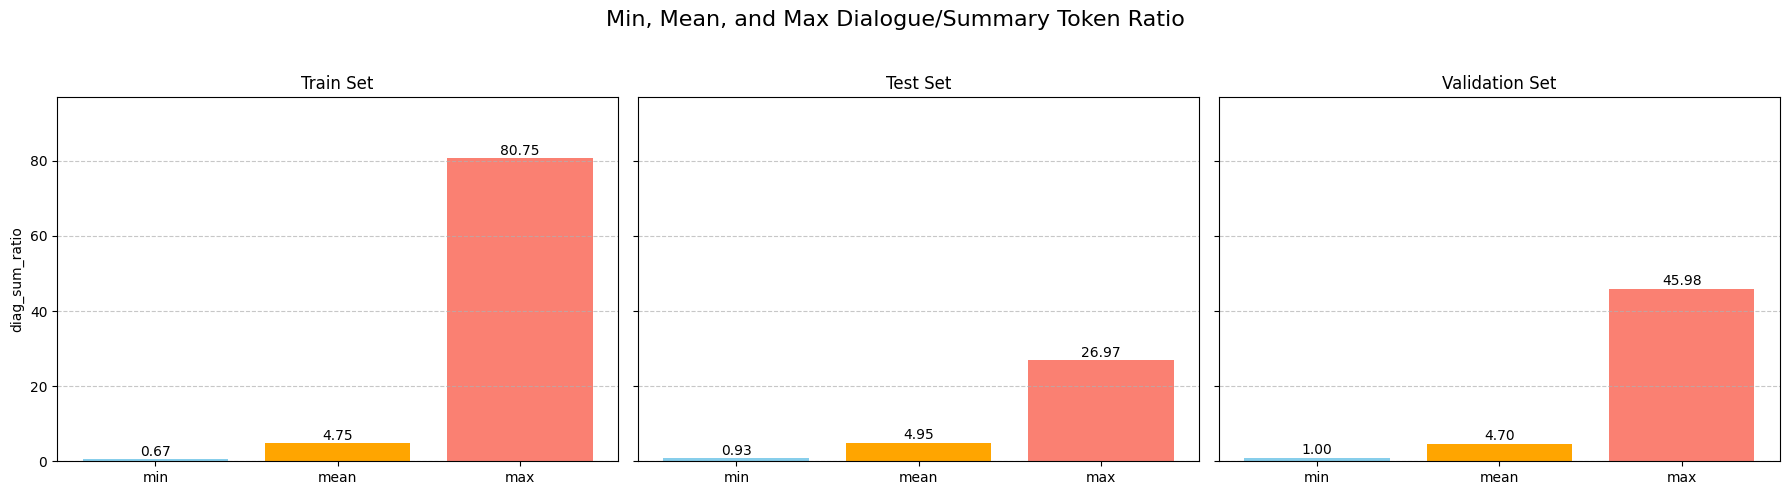

In [18]:
# Function to gather stats for the dialogue summary ratio calculated before - min, max, mean
#Function to return token ratio minimum, maximum, and average
def get_diag_sum_stats(df):
    return {
        "min": df["diag_sum_ratio"].min(),
        "mean": df["diag_sum_ratio"].mean(),
        "max": df["diag_sum_ratio"].max()
    }

# Get results
datasets = {
    "Train": get_diag_sum_stats(train_df),
    "Test": get_diag_sum_stats(test_df),
    "Validation": get_diag_sum_stats(val_df)
}


# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
colors = ['skyblue', 'orange', 'salmon']

global_max = max(stat for stats in datasets.values() for stat in stats.values()) * 1.2

for i, (name, stats) in enumerate(datasets.items()):
    ax = axes[i]
    bars = ax.bar(stats.keys(), stats.values(), color=colors)
    ax.set_title(f"{name} Set")
    ax.set_ylim(0, global_max)
    ax.set_ylabel("diag_sum_ratio" if i == 0 else "")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.05,
            f"{height:.2f}",
            ha='center', va='bottom', fontsize=10
        )

# Final layout
fig.suptitle("Min, Mean, and Max Dialogue/Summary Token Ratio", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [19]:
# Concatenate all DF's together to get the word frequency values over all datasets
all_df = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Get all words from the dialogue column and tokenize
all_words = all_df['dialogue'].dropna().apply(lambda x: word_tokenize(x.lower()))
flat_words = [word for sublist in all_words for word in sublist]

# Get the unique values
vocab = set(flat_words)

# Print total words and unique words
print(f"Total words: {len(flat_words)}")
print(f"Unique words (vocabulary size): {len(vocab)}")

# Most common words
word_freq = Counter(flat_words)
print("Top 10 most common words:")
print(word_freq.most_common(10))

# Get top 20 most common words
top20 = word_freq.most_common(20)

Total words: 2030272
Unique words (vocabulary size): 34589
Top 10 most common words:
[(':', 196826), ('i', 67213), (',', 59190), ('.', 52498), ('?', 47778), ('you', 47431), ('!', 36868), ('the', 35053), ('to', 32320), ('it', 31102)]


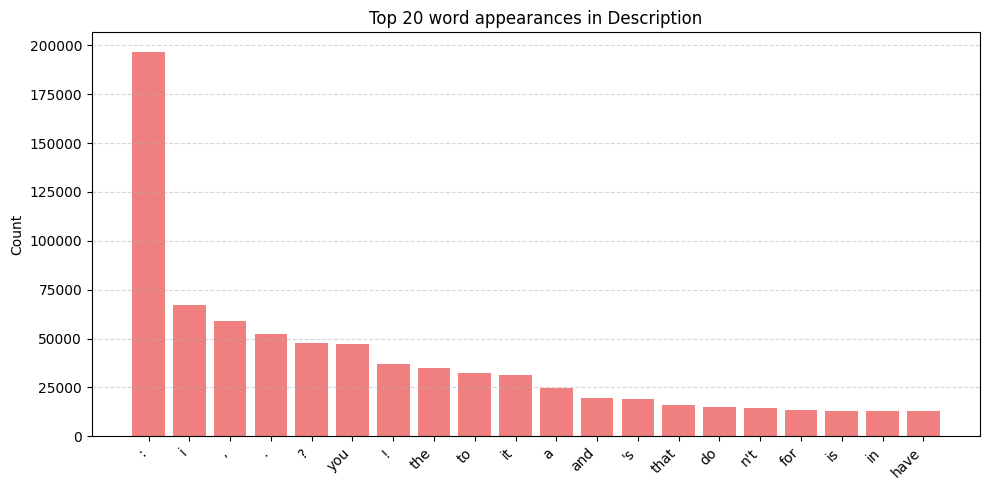

In [21]:
# Create a zip for plot
words, counts = zip(*top20)

# Plot top 20 word appearances
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 20 word appearances in Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# More EDA with BERT Tokenizer for BERT limitations check

In [22]:
# Instantiating BERT tokenizer for more EDA.  BERT is limited by 512 tokens
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
# Get count of words and tokens for each row
all_df["token_count"] = all_df["dialogue"].apply(lambda x: len(bert_tokenizer(x, truncation=False)["input_ids"]))
all_df["word_count"] = all_df["dialogue"].apply(lambda x: len(x.split()))
all_df["summary_token_count"] = all_df["summary"].apply(lambda x: len(bert_tokenizer(x, truncation=False)["input_ids"]))
all_df["summary_word_count"] = all_df["summary"].apply(lambda x: len(x.split()))

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


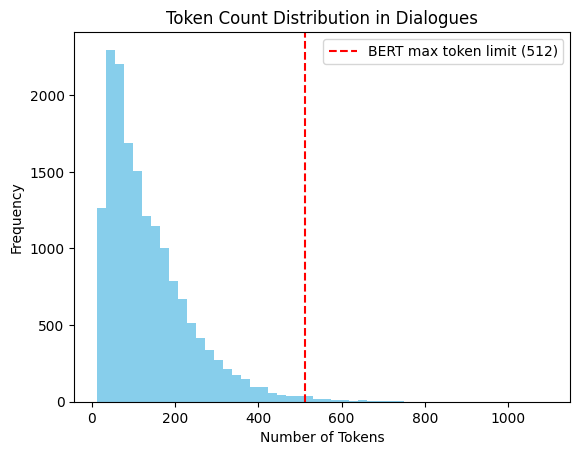

In [24]:
# Visually display token_count to see distribution
plt.hist(all_df["token_count"], bins=50, color='skyblue')
plt.axvline(512, color='red', linestyle='--', label='BERT max token limit (512)')
plt.title("Token Count Distribution in Dialogues")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

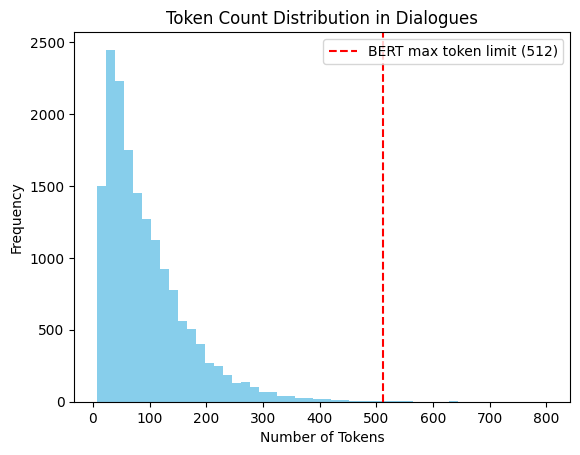

In [25]:
# Visually display word_count to see distribution
plt.hist(all_df["word_count"], bins=50, color='skyblue')
plt.axvline(512, color='red', linestyle='--', label='BERT max token limit (512)')
plt.title("Token Count Distribution in Dialogues")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/tmp/ipython-input-3450637220.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


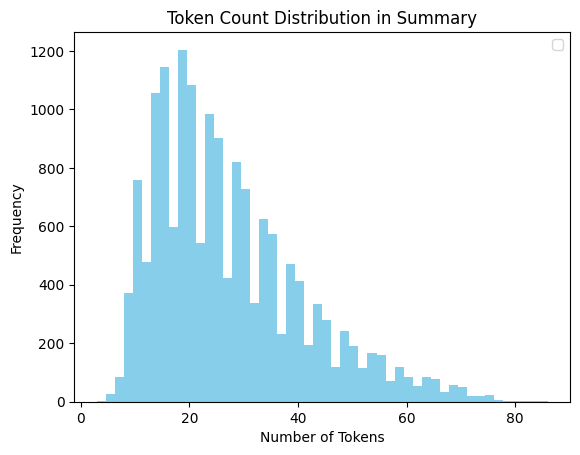

In [26]:
# Visually display token_count to see distribution
plt.hist(all_df["summary_token_count"], bins=50, color='skyblue')
#plt.axvline(512, color='red', linestyle='--', label='BERT max token limit (512)')
plt.title("Token Count Distribution in Summary")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/tmp/ipython-input-2778549092.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


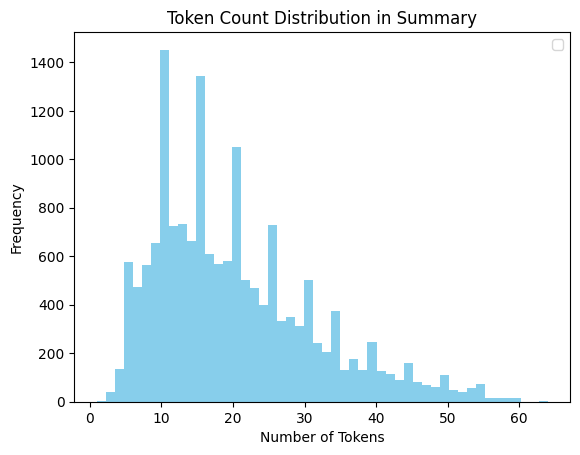

In [27]:
# Visually display word_count to see distribution
plt.hist(all_df["summary_word_count"], bins=50, color='skyblue')
#plt.axvline(512, color='red', linestyle='--', label='BERT max token limit (512)')
plt.title("Token Count Distribution in Summary")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [28]:
# Count of rows with > 512 tokens
over_512 = all_df[all_df["token_count"] > 512]
print(f"Number of rows >512 tokens: {len(over_512)}")

Number of rows >512 tokens: 127


# Function Creation for All Models

In [29]:
# Function to convert pandas DataFrames above into Datasets with proper tokenization based on tokenizer function passed in to be used for each Model
def prepare_dataset(df, tokenizer_function):
  df_dataset = Dataset.from_pandas(df)
  dataset = df_dataset.map(tokenizer_function, batched=True) # Map using proper tokenizer
  return dataset


In [30]:
max_input_length = 512
max_target_length = 128

def make_tokenize_function(tokenizer): # Pass in proper tokenizer
  def tokenize_function(examples):
      # Tokenize inputs (e.g., the dialogue)
      inputs = tokenizer(
          examples["dialogue_clean"], # Use clean dialogue
          padding="max_length",
          truncation=True,
          max_length=max_input_length, # Max length is 512 for input
      )

      # Tokenize targets
      with tokenizer.as_target_tokenizer():
          labels = tokenizer(
              examples["summary_clean"], # Use cleaned dataset
              padding="max_length",
              truncation=True, #truncate if too long
              max_length=max_target_length # Max length is 128 for target
          ).input_ids

      # Replace pad token ids with -100 so they're ignored in loss computation
      labels = [
          [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
          for label_seq in labels
      ]

      inputs["labels"] = labels
      return inputs
  return tokenize_function # Return results of tokenize function

In [31]:
# Function to flatten lists for calculating Rouge Scores
def flatten_ids(x):
    # Recursively unwrap lists
    flat = []
    if isinstance(x, (list, tuple, np.ndarray)):
        for item in x:
            flat.extend(flatten_ids(item))
    else:
        flat.append(int(x))
    return flat

In [32]:
rouge = evaluate.load("rouge")

def build_compute_metrics(tokenizer):
  def compute_metrics(eval_pred):
      predictions, labels = eval_pred
      decoded_preds = []
      decoded_labels = []

      # Loop through predictions and labels
      for i, (pred_ids, label_ids) in enumerate(tqdm(zip(predictions, labels), total=len(predictions), desc="Decoding")):
          try:
              # Flatten if needed
              pred_ids = flatten_ids(pred_ids)
              label_ids = flatten_ids(label_ids)


              label_ids = [tokenizer.pad_token_id if id == -100 else id for id in label_ids]

              # Decode predictions and labels
              decoded_pred = tokenizer.decode(pred_ids, skip_special_tokens=True).strip()
              decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True).strip()

              #Add to lists created before loop
              decoded_preds.append(decoded_pred)
              decoded_labels.append(decoded_label)

          except Exception as e:
              print(f"[ERROR] Failed to decode example {i}: {e}")
              print(f"  Raw pred_ids: {pred_ids}")
              print(f"  Raw label_ids: {label_ids}")

      if not decoded_preds:
          raise ValueError("All decoding failed. Inspect `predictions` and `labels` structure.")

      # Compute rouge scores to the 4th decimal place
      result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
      result = {key: value * 100 for key, value in result.items()}
      return {k: round(v, 4) for k, v in result.items()}
  return compute_metrics

# Data Preprocessing

In [33]:
# Function for cleaning data
def clean_text(text: str) -> str:
    # Normalize unicode - smart quotes, accented characters
    text = unicodedata.normalize("NFKC", text)

    # Remove extra whitespaces
    text = text.strip()
    text = re.sub(r"\s+", " ", text)

    #Remove any HTML tags
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"&[a-z]+;", "", text)

    # Remove space between persons name and colon
    text = re.sub(r"\s+([?.!,])", r"\1", text)

    return text

In [34]:
# Function for preprocessing raw data into clean text
def preprocess(table):
    table["dialogue_clean"] = table["dialogue"].apply(clean_text)
    table["summary_clean"] = table["summary"].apply(clean_text)
    return table




In [35]:
# Clean Training DF text
train_df = preprocess(train_df)

#Clean Test DF text
test_df = preprocess(test_df)

# Clean validation DF text
val_df = preprocess(val_df)

# Clean All DF text
all_df = preprocess(all_df)

# Create a subset of train_df for original modeling for speed purposes
subset_df = train_df.sample(n=200, random_state=42)
subset_test_df = val_df.sample(n=20, random_state=42)

In [36]:
# View top 5 rows again
train_df.head()

,id,dialogue,summary,dialogue_length,summary_length,diag_sum_ratio,dialogue_clean,summary_clean
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...,92,56,1.642857,Amanda: I baked cookies. Do you want some? Jer...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,108,61,1.770492,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...,519,77,6.740260,"Tim: Hi, what's up? Kim: Bad mood tbh, I was g...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,152,97,1.567010,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com...",888,145,6.124138,Sam: hey overheard rick say something Sam: i d...,"Sam is confused, because he overheard Rick com..."


## Base Model - BERT2BERT

In [37]:
# Instantiate a BERT Tokenizer.
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

encoder_model = "bert-base-uncased"
decoder_model = "bert-base-uncased"

encoder_config = BertConfig.from_pretrained(encoder_model)
decoder_config = BertConfig.from_pretrained(decoder_model)

# Set decoder configs
decoder_config.is_decoder = True
decoder_config.add_cross_attention = True

# Create base model BERT2BERT
base_model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model,
    encoder_config=encoder_config,
    decoder_config=decoder_config
)

# Set token variables
base_model.config.decoder_start_token_id = bert_tokenizer.cls_token_id
base_model.config.pad_token_id = bert_tokenizer.pad_token_id
base_model.config.eos_token_id = bert_tokenizer.sep_token_id

# Set model configurations
base_model.config.vocab_size = base_model.config.encoder.vocab_size
base_model.generation_config = GenerationConfig(
    decoder_start_token_id=bert_tokenizer.cls_token_id,
    pad_token_id=bert_tokenizer.pad_token_id,
    eos_token_id=bert_tokenizer.sep_token_id,
    max_length=128,
    no_repeat_ngram_size=3,
    num_beams=4,
    length_penalty=1.2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [39]:

# Test sample output before training
sample_input = "amanda : i baked cookies. do you want some? jerry : sure! amanda : i'll bring you tomorrow :)"

inputs = bert_tokenizer(sample_input, return_tensors="pt", truncation=True, padding=True).to(base_model.device)

generated_ids = base_model.generate(**inputs)

print(bert_tokenizer.decode(generated_ids[0], skip_special_tokens=True))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
`cache.key_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].keys` instead.
`cache.value_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].values` instead.


... and and and.. ; ;. and counter counter counter.. whereas counter counter and and counter and counter. and then then then counter counter so so so then then and and so so and and whereas then then so so counter counter then then step step step counter counter step step and and step step steps step step follow follow follow step step stepping step step so so follow follow counter counter follow follow and and follow follow meet meet meet step step meet meet counter counter meet meet and and meet meet follow meet follow follow function function function counter counter sink step step tap step step sink sink sink counter counter function function step step click step


In [40]:
# Start an instance of the tokenizer function to be used for dataset creation
bert_tokenize_function = make_tokenize_function(bert_tokenizer)

# Convert Dataframes into Datasets for model using bert_tokenize_function above
bert_train_dataset = prepare_dataset(train_df, bert_tokenize_function)
bert_val_dataset = prepare_dataset(val_df, bert_tokenize_function)
bert_test_dataset = prepare_dataset(test_df, bert_tokenize_function)
bert_subset_dataset = prepare_dataset(subset_df, bert_tokenize_function)
bert_subset_test_dataset = prepare_dataset(subset_test_df, bert_tokenize_function)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [41]:
bert_training_args = Seq2SeqTrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=16, # Batch size 16 ran successfully
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15, # 15 epochs - more epochs, RougeL gets better, but model is overfitting
    learning_rate=0.00003, # Tried 5e-5, 1e-5, 2e-5, 3e-6, 5e-6
    warmup_steps=400,
    lr_scheduler_type="linear", # Linear learning rate scheduler with 400 warmup steps
    predict_with_generate=True,
    logging_dir=None,
    weight_decay=0.01,
    max_grad_norm=0.9, # for stable learning
    label_smoothing_factor=0.1, # for stable learning
    logging_strategy="epoch",
    save_total_limit=1,
    eval_strategy="epoch", #evaluate after epochs
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL", # Use rougeL as evaluation metric
    greater_is_better=True,
    fp16=True,
    report_to="none"
)



In [42]:
data_collator = DataCollatorForSeq2Seq(tokenizer=bert_tokenizer, model=base_model)
compute_metrics_fn = build_compute_metrics(bert_tokenizer)

bert_trainer = Seq2SeqTrainer(
    model=base_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_val_dataset,
    #train_dataset=bert_subset_dataset,
    #eval_dataset=bert_subset_dataset,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics_fn,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/tmp/ipython-input-469276809.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  bert_trainer = Seq2SeqTrainer(


In [43]:
torch.cuda.empty_cache()

In [44]:
# Train the model
bert_trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,27.793600,5.084444,16.248400,2.908000,13.429600,13.439900
2,19.465700,4.450640,23.680900,5.012600,19.124200,19.130200
3,16.958200,4.107607,30.062300,7.848100,23.974200,24.006800
4,15.594300,3.971034,32.944100,9.773500,26.041100,26.051700
5,14.719400,3.899269,34.208400,10.107600,26.334400,26.320700
6,14.045600,3.862458,35.678400,10.605100,27.798100,27.798400
7,13.494000,3.852675,35.848900,10.902600,28.116500,28.103500
8,13.022800,3.842318,36.785200,11.338900,28.094200,28.101800
9,12.631400,3.841894,37.226000,11.918500,28.977000,28.962300
10,12.302100,3.854510,37.739800,11.863600,29.010600,29.016600


/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Decoding: 100%|██████████| 818/818 [00:02<00:00, 407.78it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a b

TrainOutput(global_step=3003, training_loss=15.032476719244297, metrics={'train_runtime': 5079.9181, 'train_samples_per_second': 43.498, 'train_steps_per_second': 0.682, 'total_flos': 1.1747830060422144e+17, 'train_loss': 15.032476719244297, 'epoch': 13.0})

In [51]:
# Sample output after model training on same text as before
sample_input = "[amanda]: i baked cookies. do you want some? [jerry]: sure! [amanda]: i'll bring you tomorrow :)"

sample_input = clean_text(sample_input)

inputs = bert_tokenizer(sample_input, return_tensors="pt", truncation=True, padding=True).to(base_model.device)

generated_ids = base_model.generate(**inputs)

print(bert_tokenizer.decode(generated_ids[0], skip_special_tokens=True))

jerry baked jerry's baked cookies.


In [47]:
# Calculate the metrics on the test dataset
bert_metrics = bert_trainer.evaluate(bert_test_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Decoding: 100%|██████████| 819/819 [00:01<00:00, 412.30it/s]


In [48]:
# Print results
print(bert_metrics)

{'eval_loss': 3.8680872917175293, 'eval_rouge1': 38.1765, 'eval_rouge2': 12.4003, 'eval_rougeL': 29.5514, 'eval_rougeLsum': 29.5317, 'eval_runtime': 133.1157, 'eval_samples_per_second': 6.153, 'eval_steps_per_second': 0.391, 'epoch': 13.0}


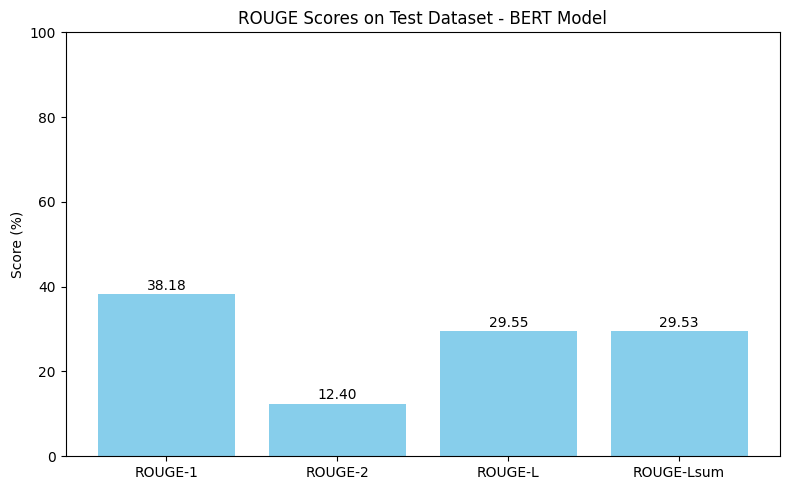

In [49]:
# Create plot for Rouge scores.  First needed to get results from metrics results
rouge_scores = {
    "ROUGE-1": bert_metrics["eval_rouge1"],
    "ROUGE-2": bert_metrics["eval_rouge2"],
    "ROUGE-L": bert_metrics["eval_rougeL"],
    "ROUGE-Lsum": bert_metrics["eval_rougeLsum"],
}

plt.figure(figsize=(8, 5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("ROUGE Scores on Test Dataset - BERT Model")

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [84]:
small_test_set = bert_test_dataset.select(range(5))
outputs = bert_trainer.predict(small_test_set)
predictions = bert_tokenizer.batch_decode(outputs.predictions, skip_special_tokens=True)
dialogues = [ex["dialogue_clean"] for ex in small_test_set]
references = [ex["summary_clean"] for ex in small_test_set]
for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Decoding: 100%|██████████| 5/5 [00:00<00:00, 382.82it/s]



Dialogue: Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah:  Amanda: Sorry, can't find it. Amanda: Ask Larry Amanda: He called her last time we were at the park together Hannah: I don't know him well Hannah:  Amanda: Don't be shy, he's very nice Hannah: If you say so.. Hannah: I'd rather you texted him Amanda: Just text him 🙂 Hannah: Urgh.. Alright Hannah: Bye Amanda: Bye bye

Predicted: betty wants to ask hannah for her phone number. hannah doesn't know if she's at home.
Target:    Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


Dialogue: Eric: MACHINE! Rob: That's so gr8! Eric: I know! And shows how Americans see Russian ;) Rob: And it's really funny! Eric: I know! I especially like the train part! Rob: Hahaha! No one talks to the machine like that! Eric: Is this his only stand-up? Rob: Idk. I'll check. Eric: Sure. Rob: Turns out no! There are some of his stand-ups on youtube. Eric: Gr8! I'll watch them now! Rob: Me too! Eric:

/content


In [53]:
# Save model to google drive
bert_trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum")
bert_tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum')

('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum/added_tokens.json')

## Pegasus Implementation

In [85]:
# Load in pegasus model and trainer
model_name = "google/pegasus-xsum"  # You can also try "google/pegasus-large"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [86]:
# Instantiate a version of tokenizer function with pegasus tokenizer
pegasus_tokenize_function = make_tokenize_function(pegasus_tokenizer)

# Create datasets
pegasus_train_dataset = prepare_dataset(train_df, pegasus_tokenize_function)
pegasus_test_dataset = prepare_dataset(test_df, pegasus_tokenize_function)
pegasus_val_dataset = prepare_dataset(val_df, pegasus_tokenize_function)
pegasus_subset_dataset = prepare_dataset(subset_df, pegasus_tokenize_function)
pegasus_subset_test_dataset = prepare_dataset(subset_test_df, pegasus_tokenize_function)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [91]:
# Training arguments for pegasus
pegasus_training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/Pegasus",
    per_device_train_batch_size=16, # Needed smaller batch size
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    learning_rate=0.00003,
    warmup_steps=400,
    lr_scheduler_type="linear",
    predict_with_generate=True,
    logging_dir=None,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_total_limit=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL",
    greater_is_better=True,
    fp16=True,
    report_to="none"
)



In [92]:
data_collator = DataCollatorForSeq2Seq(tokenizer=pegasus_tokenizer, model=pegasus_model)
# Create a version of compute metrics function with pegasus tokenizer
compute_metrics_fn = build_compute_metrics(pegasus_tokenizer)

pegasus_trainer = Seq2SeqTrainer(
    model=pegasus_model,
    args=pegasus_training_args,
    train_dataset=pegasus_train_dataset,
    eval_dataset=pegasus_val_dataset,
    #train_dataset=bert_subset_dataset,
    #eval_dataset=bert_subset_dataset,
    tokenizer=pegasus_tokenizer,
    compute_metrics=compute_metrics_fn,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/tmp/ipython-input-1883098625.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  pegasus_trainer = Seq2SeqTrainer(


In [93]:
torch.cuda.empty_cache()

In [94]:
# Train the model
pegasus_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.302700,1.732340,41.638600,19.023200,34.997500,35.059700
2,2.066200,1.726359,41.807300,19.150100,35.103100,35.149000
3,1.999800,1.726362,41.850500,19.232700,35.190700,35.217500
4,2.041500,1.726369,41.826100,19.179300,35.120500,35.159700
5,2.026900,1.726354,41.795700,19.193300,35.127600,35.170200


Decoding: 100%|██████████| 818/818 [00:10<00:00, 78.61it/s]
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3852: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Decoding: 100%|██████████| 818/818 [00:10<00:00, 79.74it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1155, training_loss=2.0874004413555194, metrics={'train_runtime': 3027.7062, 'train_samples_per_second': 72.981, 'train_steps_per_second': 1.144, 'total_flos': 1.0641175071424512e+17, 'train_loss': 2.0874004413555194, 'epoch': 5.0})

In [95]:
# Compute metrics
pegasus_metrics = pegasus_trainer.evaluate(pegasus_test_dataset)

Decoding: 100%|██████████| 819/819 [00:10<00:00, 80.08it/s]


In [96]:
# Print metrics
print(pegasus_metrics)

{'eval_loss': 1.7392189502716064, 'eval_rouge1': 42.079, 'eval_rouge2': 19.6021, 'eval_rougeL': 35.585, 'eval_rougeLsum': 35.6228, 'eval_runtime': 217.8094, 'eval_samples_per_second': 3.76, 'eval_steps_per_second': 0.239, 'epoch': 5.0}


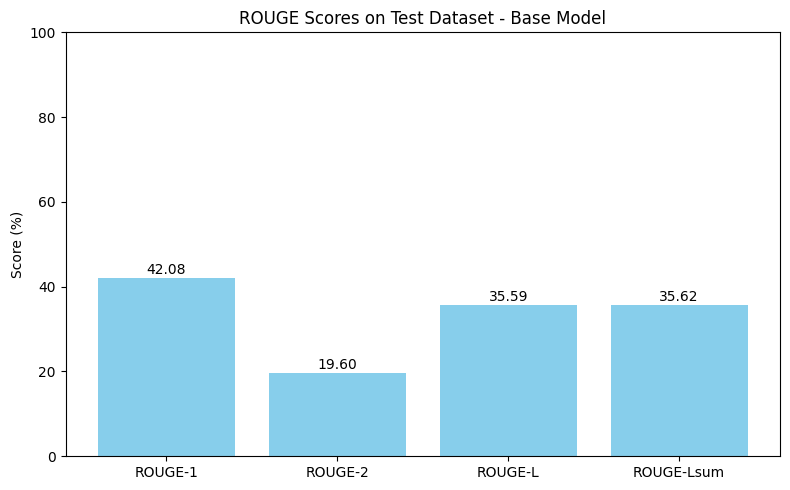

In [97]:
# Plot Rouge scores
rouge_scores = {
    "ROUGE-1": pegasus_metrics["eval_rouge1"],
    "ROUGE-2": pegasus_metrics["eval_rouge2"],
    "ROUGE-L": pegasus_metrics["eval_rougeL"],
    "ROUGE-Lsum": pegasus_metrics["eval_rougeLsum"],
}

plt.figure(figsize=(8, 5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("ROUGE Scores on Test Dataset - Base Model")

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [98]:
# Save Pegasus model
pegasus_trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum")
pegasus_tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum')

('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum/added_tokens.json')

## BART implementation

In [54]:
# BART Tokenizer
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# BART Model
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [55]:
# Create instance of tokenize function with bart tokenizer
bart_tokenize_function = make_tokenize_function(bart_tokenizer)

# Apply tokenization using bart_tokenize_function to create datasets
bart_train_dataset = prepare_dataset(train_df, bart_tokenize_function)
bart_val_dataset = prepare_dataset(val_df, bart_tokenize_function)
bart_test_dataset = prepare_dataset(test_df, bart_tokenize_function)
bart_subset_dataset = prepare_dataset(subset_df, bart_tokenize_function)
bart_subset_test_dataset = prepare_dataset(subset_test_df, bart_tokenize_function)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [56]:
# Training Arguments -
bart_training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bart_summation",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    learning_rate=3e-5,
    weight_decay=0.01,
    max_grad_norm=0.9,
    label_smoothing_factor=0.1,
    save_total_limit=1,
    save_strategy="epoch",
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL",
    greater_is_better=True,
    logging_dir=None,
    report_to="none",
)


In [57]:
data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

# Verision of compute metrics with bart tokenizer
compute_metrics_fn = build_compute_metrics(bart_tokenizer)

bart_trainer = Seq2SeqTrainer(
    model=bart_model,
    args=bart_training_args,
    train_dataset=bart_train_dataset,
    eval_dataset=bart_val_dataset,
    #train_dataset=bart_subset_dataset,
    #eval_dataset=bart_subset_dataset,
    processing_class=bart_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [58]:
torch.cuda.empty_cache()

In [68]:
# Train
bart_trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,3.370500,3.001369,46.944900,22.911500,39.025600,39.047900
2,3.089300,2.917435,47.114900,23.911700,39.843200,39.822900
3,2.989500,2.887736,47.706200,24.628000,40.566800,40.603500
4,2.919800,2.865537,47.741400,24.638600,40.387800,40.384700
5,2.862200,2.855183,49.126200,25.891200,41.355900,41.387600
6,2.818500,2.841003,49.097000,25.629200,41.415600,41.415300
7,2.779400,2.833936,48.772600,25.553300,41.086700,41.094100
8,2.747500,2.836098,48.738100,25.607200,41.232200,41.209600


Decoding: 100%|██████████| 818/818 [00:01<00:00, 455.50it/s]
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3852: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Decoding: 100%|██████████| 818/818 [00:01<00:00, 456.16it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=928, training_loss=2.9470968575313172, metrics={'train_runtime': 1182.0421, 'train_samples_per_second': 186.935, 'train_steps_per_second': 1.472, 'total_flos': 3.592811106533376e+16, 'train_loss': 2.9470968575313172, 'epoch': 8.0})

In [70]:
# Get rouge scores
bart_metrics = bart_trainer.evaluate(bart_test_dataset)

Decoding: 100%|██████████| 819/819 [00:01<00:00, 447.22it/s]


In [71]:
print(bart_metrics)

{'eval_loss': 2.864987373352051, 'eval_rouge1': 47.4899, 'eval_rouge2': 24.0888, 'eval_rougeL': 40.0446, 'eval_rougeLsum': 40.0453, 'eval_runtime': 39.5439, 'eval_samples_per_second': 20.711, 'eval_steps_per_second': 1.315, 'epoch': 8.0}


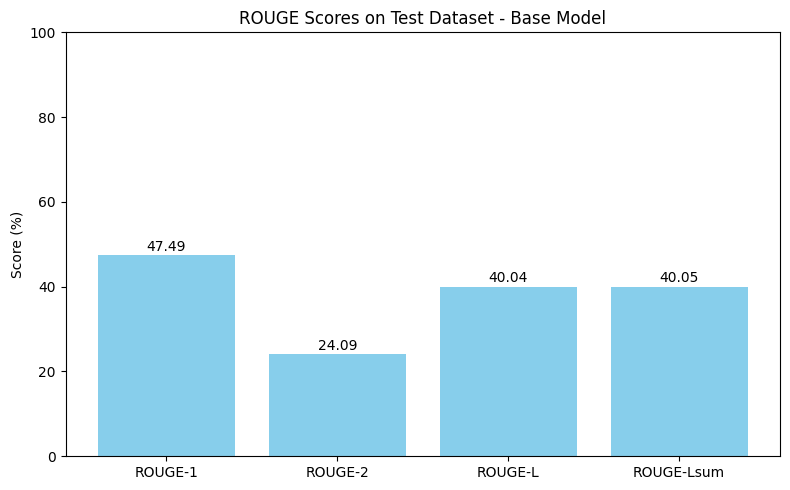

In [72]:
# Plot rouge scores
rouge_scores = {
    "ROUGE-1": bart_metrics["eval_rouge1"],
    "ROUGE-2": bart_metrics["eval_rouge2"],
    "ROUGE-L": bart_metrics["eval_rougeL"],
    "ROUGE-Lsum": bart_metrics["eval_rougeLsum"],
}

plt.figure(figsize=(8, 5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("ROUGE Scores on Test Dataset - Base Model")

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [73]:
# Save BART model
bart_trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum")
bart_tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum')

('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum/added_tokens.json')

## T5 Implementation

In [74]:
# Load T5 pretrained model and tokenizer
model_name = "t5-base"
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [75]:
# Create instance of tokenizer function with T5 tokenizer
t5_tokenize_function = make_tokenize_function(t5_tokenizer)

# Apply tokenization
t5_train_dataset = prepare_dataset(train_df, t5_tokenize_function)
t5_val_dataset = prepare_dataset(val_df, t5_tokenize_function)
t5_test_dataset = prepare_dataset(test_df, t5_tokenize_function)
t5_subset_dataset = prepare_dataset(subset_df, t5_tokenize_function)
t5_subset_test_dataset = prepare_dataset(subset_test_df, t5_tokenize_function)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [76]:
# Training Arguments
t5_training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/t5_summarization",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=15,
    predict_with_generate=True,
    metric_for_best_model="eval_rougeL",
    greater_is_better=True,
    load_best_model_at_end=True,
    save_strategy="epoch",
    fp16=True,
    #bf16=True,
    report_to="none"
)

In [77]:
# Create version of compute metrics with T5 tokenizer
compute_metrics_fn = build_compute_metrics(t5_tokenizer)

t5_trainer = Seq2SeqTrainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=t5_train_dataset,
    eval_dataset=t5_val_dataset,
    #train_dataset=t5_subset_dataset,
    #eval_dataset=t5_subset_dataset,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/tmp/ipython-input-3931386756.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  t5_trainer = Seq2SeqTrainer(


In [78]:
torch.cuda.empty_cache()

In [79]:
# Train
t5_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.508375,45.153600,21.039200,37.655500,37.668100
2,No log,1.461140,46.109200,22.165000,38.475900,38.502700
3,1.718700,1.436220,46.566500,22.688300,38.991700,39.038700
4,1.718700,1.501164,45.613900,21.096500,37.793900,37.834000
5,1.606800,1.492778,45.637500,21.163600,37.809800,37.802000


Decoding: 100%|██████████| 818/818 [00:08<00:00, 96.69it/s]


[ERROR] Failed to decode example 816: piece id is out of range.
  Raw pred_ids: [0, 1571, 651, 8238, 160, 11477, 5, 7138, 9, 56, 580, 160, 4806, 1565, 5, 1, 0, 0, 0, 0, -100]
  Raw label_ids: [1571, 651, 8238, 160, 11477, 11, 65, 3, 9, 1088, 5721, 5, 7138, 9, 56, 580, 3, 9, 8602, 23, 152, 24, 255, 4054, 11, 752, 1571, 651, 214, 3, 99, 255, 54, 199, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ERROR] Failed to decode example 817: piece id is out of range.
  Raw pred_ids: [0, 11712, 56, 1299, 8, 18165, 12, 14697, 397, 57, 2664, 1332, 5, 1, 0, 0, 0, 0, 0, 0, -100]
  Raw label_ids: [14697, 397, 2746, 12, 43, 8, 18165, 1622, 865, 5, 11712, 2746, 12, 1299, 34, 1116, 5, 37, 7183, 21, 1942, 19, 2664, 1332, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Decoding: 100%|██████████| 818/818 [00:08<00:00, 96.05it/s]
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1155, training_loss=1.6600077971751557, metrics={'train_runtime': 2035.7103, 'train_samples_per_second': 108.544, 'train_steps_per_second': 1.702, 'total_flos': 4.48527934291968e+16, 'train_loss': 1.6600077971751557, 'epoch': 5.0})

In [80]:
# Get metrics
t5_metrics = t5_trainer.evaluate(t5_test_dataset)

Decoding: 100%|██████████| 819/819 [00:08<00:00, 96.89it/s]


In [81]:
print(t5_metrics)

{'eval_loss': 1.4480012655258179, 'eval_rouge1': 45.3258, 'eval_rouge2': 20.899, 'eval_rougeL': 37.1246, 'eval_rougeLsum': 37.1554, 'eval_runtime': 62.0635, 'eval_samples_per_second': 13.196, 'eval_steps_per_second': 0.838, 'epoch': 5.0}


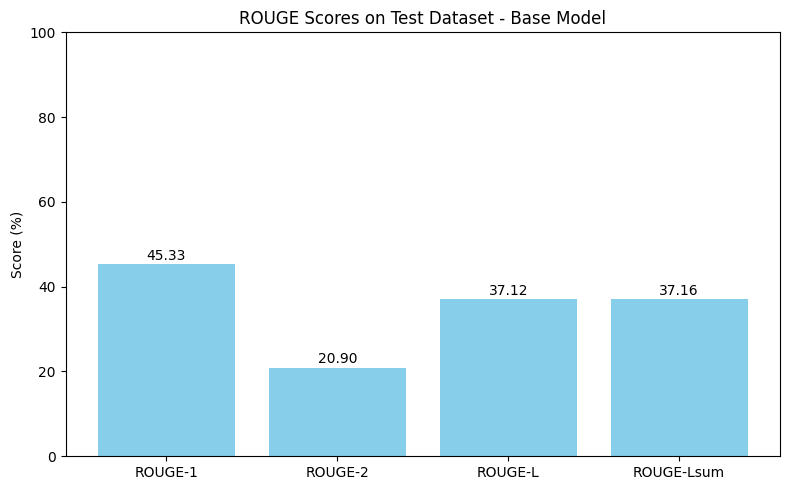

In [82]:
# Plot Rouge scores
rouge_scores = {
    "ROUGE-1": t5_metrics["eval_rouge1"],
    "ROUGE-2": t5_metrics["eval_rouge2"],
    "ROUGE-L": t5_metrics["eval_rougeL"],
    "ROUGE-Lsum": t5_metrics["eval_rougeLsum"],
}

plt.figure(figsize=(8, 5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("ROUGE Scores on Test Dataset - Base Model")

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [83]:
# Save T5 model
t5_trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum")
t5_tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum')

('/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum/added_tokens.json')

# Evaluations Of All Models Together

### This step can be run after all models have been successfully trained and metrics calculated.

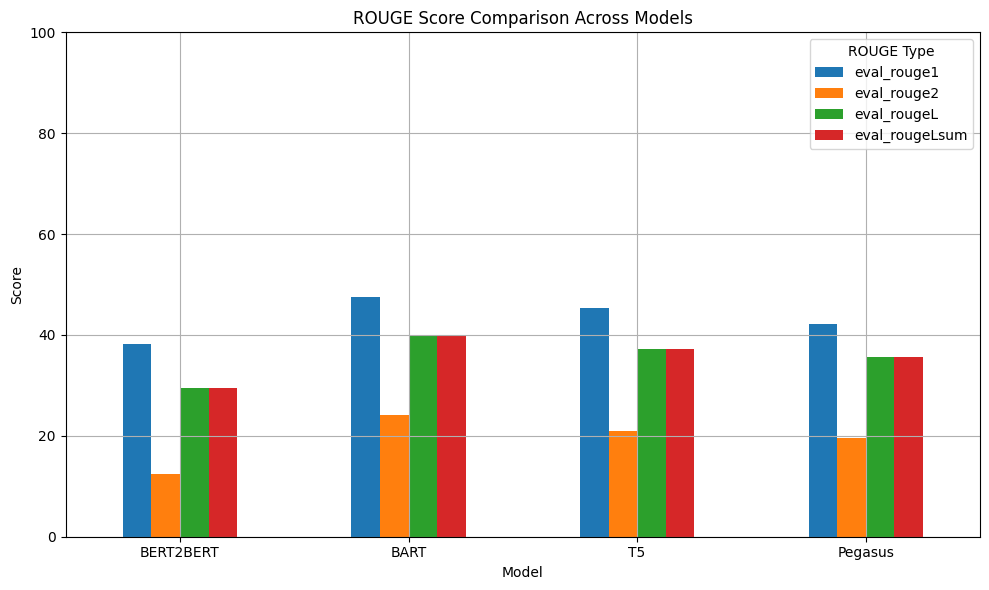

In [100]:
# Keys to look for for Rouge Scores
rouge_keys = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']

# Get only rouge scores from the metrics calculated after each dataset
bert_rouge = {k: v for k, v in bert_metrics.items() if k in rouge_keys}
bart_rouge = {k: v for k, v in bart_metrics.items() if k in rouge_keys}
t5_rouge = {k: v for k, v in t5_metrics.items() if k in rouge_keys}
pegasus_rouge = {k: v for k, v in pegasus_metrics.items() if k in rouge_keys}

# Plot all rouge scores from each dataset onto one graph for easy to display
rouge_df = pd.DataFrame({
    'BERT2BERT': bert_rouge,
    'BART': bart_rouge,
    'T5': t5_rouge,
    'Pegasus': pegasus_rouge
})


rouge_df.T.plot(kind='bar', figsize=(10,6))
plt.title("ROUGE Score Comparison Across Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="ROUGE Type")
plt.grid(True)
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Display 5 exampleas of each Model

In [101]:
# Grab 5 random samples from test dataframe
small_test_df = test_df.sample(n=5, random_state=None)

### BERT Examples

In [102]:
# Tokenize dataset
bert_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(bert_tokenizer))

# Get predictions from model
outputs = bert_trainer.predict(bert_small_test_set)

# Get expected output
dialogues = [ex["dialogue_clean"] for ex in bert_small_test_set]

# Decode predictions
predictions = bert_tokenizer.batch_decode(outputs.predictions, skip_special_tokens=True)

# Get expected summary results
references = [ex["summary_clean"] for ex in bert_small_test_set]

# Print all results
for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained

Decoding: 100%|██████████| 5/5 [00:00<00:00, 390.04it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: nathalie and olaf are going to the new year's eve party in london.
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's Warsaw in

### BART examples

In [103]:
# Tokenize dataset
bart_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(bart_tokenizer))

# Get predictions from model
outputs = bart_trainer.predict(bart_small_test_set)

# Get original text
dialogues = [ex["dialogue_clean"] for ex in bart_small_test_set]

# Decode outputs
predictions = bart_tokenizer.batch_decode(outputs.predictions, skip_special_tokens=True)

# Get expected summaries
references = [ex["summary_clean"] for ex in bart_small_test_set]

# Print results
for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 421.24it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Nathalie and Olafur are going to Soho for New Year's Eve
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's Warsaw ink Javier: 

### Pegasus examples

In [104]:
pegasus_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(pegasus_tokenizer))

outputs = pegasus_trainer.predict(pegasus_small_test_set)

dialogues = [ex["dialogue_clean"] for ex in pegasus_small_test_set]
predictions = pegasus_tokenizer.batch_decode(outputs.predictions, skip_special_tokens=True)
references = [ex["summary_clean"] for ex in pegasus_small_test_set]

for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 78.36it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Olafur wants to propose to Nathalie on New Year's Eve.
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's Warsaw ink Javier: th

### T5 examples

In [105]:
t5_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(t5_tokenizer))

outputs = t5_trainer.predict(t5_small_test_set)

dialogues = [ex["dialogue_clean"] for ex in t5_small_test_set]
predictions = t5_tokenizer.batch_decode(outputs.predictions, skip_special_tokens=True)
references = [ex["summary_clean"] for ex in t5_small_test_set]

for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 94.63it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Nathalie is thinking about something classy for New Year's Eve. She proposes
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's

## Function for summarizing an input text with specific model type, default BERT

In [106]:
# Takes in text for input and text for model.  default model is BERT2BERT
def summarize_chat(chat_input: str, model_name: str='BERT'):
  # Lowercase model name
  model_name = model_name.lower()
  # If bart, enter
  if model_name == 'bart':
    # Tokenize input text
    inputs = bart_tokenizer(chat_input, return_tensors="pt", truncation=True, padding=True).to(bart_model.device)
    #Generate prediction
    generated_ids = bart_model.generate(**inputs)
    # Decode and print output
    print(f"BART Summary: {bart_tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")
    # return Decoded output
    return bart_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  elif model_name == 'pegasus':
    # Tokenize input text
    inputs = pegasus_tokenizer(chat_input, return_tensors="pt", truncation=True, padding=True).to(pegasus_model.device)
    #Generate prediction
    generated_ids = pegasus_model.generate(**inputs)
    # Decode and print output
    print(f"Pegasus Summary: {pegasus_tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")
    # return Decoded output
    return pegasus_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  elif model_name =='t5':
    # Tokenize input text
    inputs = t5_tokenizer(chat_input, return_tensors="pt", truncation=True, padding=True).to(t5_model.device)
    #Generate prediction
    generated_ids = t5_model.generate(**inputs)
    # Decode and print output
    print(f"T5 Summary: {t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")
    # return Decoded output
    return t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  else:
    # Tokenize input text
    inputs = bert_tokenizer(chat_input, return_tensors="pt", truncation=True, padding=True).to(base_model.device)
    #Generate prediction
    generated_ids = base_model.generate(**inputs)
    # Decode and print output
    print(f"BERT Summary: {bert_tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")
    # return Decoded output
    return bert_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [108]:
# Two test examples to be summarized.  Both called directly below and prints will automatically happen in the function call
chat = "Andrew: I have to go to the bathroom.  James: There is one on the 5th floor.  Andrew: Ok thanks I will use that one"
chat2 = "Andy: I wonder how long it will take to get a job.  CJ: 87% of people get a job in 6 months.  Andrew: I don't want to wait 6 months.  CJ: Most people find a job a lot sooner"

result_bert = summarize_chat(chat)
result_bart = summarize_chat(chat, 'Bart')
result_pegasus = summarize_chat(chat, 'pEGasus')
result_t5 = summarize_chat(chat, 'T5')
print("\n")
result_bert2 = summarize_chat(chat2, 'BERT')
result_bart2 = summarize_chat(chat2, 'Bart')
result_pegasus2 = summarize_chat(chat2, 'pEGasus')
result_t52 = summarize_chat(chat2, 'T5')

BERT Summary: andrew will go to the 5th floor in the 5th room.
BART Summary: Andrew has to go to the bathroom. James advises him to use the bathroom on the 5
Pegasus Summary: Andrew has to go to the bathroom.
T5 Summary: Andrew has to go to the bathroom. James has a bathroom on the 5th floor. Andrew


BERT Summary: andrew is looking for a job as a teacher in a few months.
BART Summary:  87% of people get a job in 6 months.
Pegasus Summary: Andy and CJ want to know how long it will take to get a job.
T5 Summary: CJ says 87% of people get a job in 6 months. Andrew wants to wait 6


# This section loads models from saved directory off Google Drive
### BERT - Loading in BERT2BERT Model then evaluating on Test Dataset

In [73]:
# Path to previously saved BERT model
bert_path = '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/bert2bert-samsum'

# Load model and tokenizer
bert_model_load = EncoderDecoderModel.from_pretrained(bert_path)
bert_tokenizer_load = BertTokenizer.from_pretrained(bert_path)

In [74]:
bert_test_dataset = prepare_dataset(test_df, make_tokenize_function(bert_tokenizer_load))

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [75]:
# Base arguments for evaluation
bert_eval_args = Seq2SeqTrainingArguments(
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none"
)

data_collator_bert = DataCollatorForSeq2Seq(tokenizer=bert_tokenizer_load, model=bert_model_load)
compute_metrics_fn = build_compute_metrics(bert_tokenizer_load)

bert_load_trainer = Seq2SeqTrainer(
    model=bert_model_load,
    args=bert_eval_args,
    tokenizer=bert_tokenizer_load,  # Make sure this matches your saved tokenizer
    eval_dataset=bert_test_dataset,
    compute_metrics=compute_metrics_fn,  # If you’ve defined ROUGE or custom metrics
    data_collator=data_collator_bert
)


/tmp/ipython-input-840735719.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  bert_load_trainer = Seq2SeqTrainer(


In [76]:
# Get BERT results for plotting later
bert_results = bert_load_trainer.evaluate(bert_test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
`cache.key_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].keys` instead.
`cache.value_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].values` instead.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py

Decoding: 100%|██████████| 819/819 [00:02<00:00, 327.87it/s]


In [77]:
print(bert_results)

{'eval_loss': 2.811084270477295, 'eval_model_preparation_time': 0.0076, 'eval_rouge1': 37.6481, 'eval_rouge2': 11.964, 'eval_rougeL': 29.2288, 'eval_rougeLsum': 29.2143, 'eval_runtime': 131.0694, 'eval_samples_per_second': 6.249, 'eval_steps_per_second': 0.397}


### BART - Loading in BART model and then evaluating on test dataset

In [78]:
# Path to where BART was saved
bart_path = '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/BART-samsum'

# Load previously saved BART model
bart_model_load = BartForConditionalGeneration.from_pretrained(bart_path)
bart_tokenizer_load = BartTokenizer.from_pretrained(bart_path)

In [79]:
# Prepare Test Dataset
bart_test_dataset = prepare_dataset(test_df, make_tokenize_function(bart_tokenizer_load))

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [80]:
# Base arguments for evaluation on test dataset
bart_eval_args = Seq2SeqTrainingArguments(
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none"
)

data_collator_bart = DataCollatorForSeq2Seq(bart_tokenizer_load, model=bart_model_load)
compute_metrics_fn = build_compute_metrics(bart_tokenizer_load)

bart_load_trainer = Seq2SeqTrainer(
    model=bart_model_load,
    args=bart_eval_args,
    tokenizer=bart_tokenizer_load,
    eval_dataset=bert_test_dataset,
    compute_metrics=compute_metrics_fn,
    data_collator=data_collator_bart
)


/tmp/ipython-input-1178360708.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  bart_load_trainer = Seq2SeqTrainer(


In [81]:
# Get results on test dataset to be used later for plotting
bart_results = bart_load_trainer.evaluate(bart_test_dataset)

Decoding: 100%|██████████| 819/819 [00:01<00:00, 436.22it/s]


In [82]:
print(bart_results)

{'eval_loss': 1.5688440799713135, 'eval_model_preparation_time': 0.0033, 'eval_rouge1': 47.4723, 'eval_rouge2': 23.9747, 'eval_rougeL': 39.9005, 'eval_rougeLsum': 39.8966, 'eval_runtime': 38.6505, 'eval_samples_per_second': 21.19, 'eval_steps_per_second': 1.345}


### T5 - Loading in T5 model and evaluating on Test Dataset

In [83]:
# Path to T5 model
t5_path = '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/T5-samsum'

# Load previously saved T5 model and tokenizer
t5_model_load = T5ForConditionalGeneration.from_pretrained(t5_path)
t5_tokenizer_load = T5Tokenizer.from_pretrained(t5_path)

In [84]:
# Create T5 test dataset
t5_test_dataset = prepare_dataset(test_df, make_tokenize_function(t5_tokenizer_load))

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [85]:
# BAse arguments needed for evaluation
t5_eval_args = Seq2SeqTrainingArguments(
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none"
)

data_collator_t5 = DataCollatorForSeq2Seq(t5_tokenizer_load, model=t5_model_load)
compute_metrics_fn = build_compute_metrics(t5_tokenizer_load)

t5_load_trainer = Seq2SeqTrainer(
    model=t5_model_load,
    args=t5_eval_args,
    tokenizer=t5_tokenizer_load,
    eval_dataset=t5_test_dataset,
    compute_metrics=compute_metrics_fn,
    data_collator=data_collator_t5
)

/tmp/ipython-input-1798963655.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  t5_load_trainer = Seq2SeqTrainer(


In [86]:
# GEt results of T5 test dataset for Rouge for plotting later
t5_results = t5_load_trainer.evaluate(t5_test_dataset)

Decoding: 100%|██████████| 819/819 [00:08<00:00, 95.87it/s]


In [87]:
print(t5_results)

{'eval_loss': 1.4480012655258179, 'eval_model_preparation_time': 0.0058, 'eval_rouge1': 45.308, 'eval_rouge2': 20.8713, 'eval_rougeL': 37.1073, 'eval_rougeLsum': 37.1, 'eval_runtime': 61.6214, 'eval_samples_per_second': 13.291, 'eval_steps_per_second': 0.844}


### Pegasus - Loading in saved pegasus model to evaluate on Test Dataset

In [91]:
# Path to pegasus saved earlier
pegasus_path = '/content/drive/MyDrive/Colab Notebooks/Bert_TextSummarization/pegasus-samsum'

# Load pegasus model and tokenizer
pegasus_model_load = PegasusForConditionalGeneration.from_pretrained(pegasus_path)
pegasus_tokenizer_load = PegasusTokenizer.from_pretrained(pegasus_path)

In [92]:
# Create pegasus test dataset for evaluation
pegasus_test_dataset = prepare_dataset(test_df, make_tokenize_function(pegasus_tokenizer_load))

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [93]:
# Base arguments for evaluation
pegasus_eval_args = Seq2SeqTrainingArguments(
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none"
)

data_collator_pegasus = DataCollatorForSeq2Seq(pegasus_tokenizer_load, model=pegasus_model_load)
compute_metrics_fn = build_compute_metrics(pegasus_tokenizer_load)

pegasus_load_trainer = Seq2SeqTrainer(
    model=pegasus_model_load,
    args=pegasus_eval_args,
    tokenizer=pegasus_tokenizer_load,
    eval_dataset=pegasus_test_dataset,
    compute_metrics=compute_metrics_fn,
    data_collator=data_collator_pegasus
)

/tmp/ipython-input-1930389557.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  pegasus_load_trainer = Seq2SeqTrainer(


In [94]:
# Get pegasus results for plotting later
pegasus_results = pegasus_load_trainer.evaluate(pegasus_test_dataset)

Decoding: 100%|██████████| 819/819 [00:10<00:00, 77.48it/s]


In [95]:
print(pegasus_results)

{'eval_loss': 1.7903116941452026, 'eval_model_preparation_time': 0.0078, 'eval_rouge1': 39.8465, 'eval_rouge2': 17.8148, 'eval_rougeL': 33.6842, 'eval_rougeLsum': 33.6509, 'eval_runtime': 256.3884, 'eval_samples_per_second': 3.194, 'eval_steps_per_second': 0.203}


In [96]:
# Keys to look for for Rouge Scores
rouge_keys = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']

# Get only rouge scores from the datasets
bert_rouge = {k: v for k, v in bert_results.items() if k in rouge_keys}
bart_rouge = {k: v for k, v in bart_results.items() if k in rouge_keys}
t5_rouge = {k: v for k, v in t5_results.items() if k in rouge_keys}
pegasus_rouge = {k: v for k, v in pegasus_results.items() if k in rouge_keys}

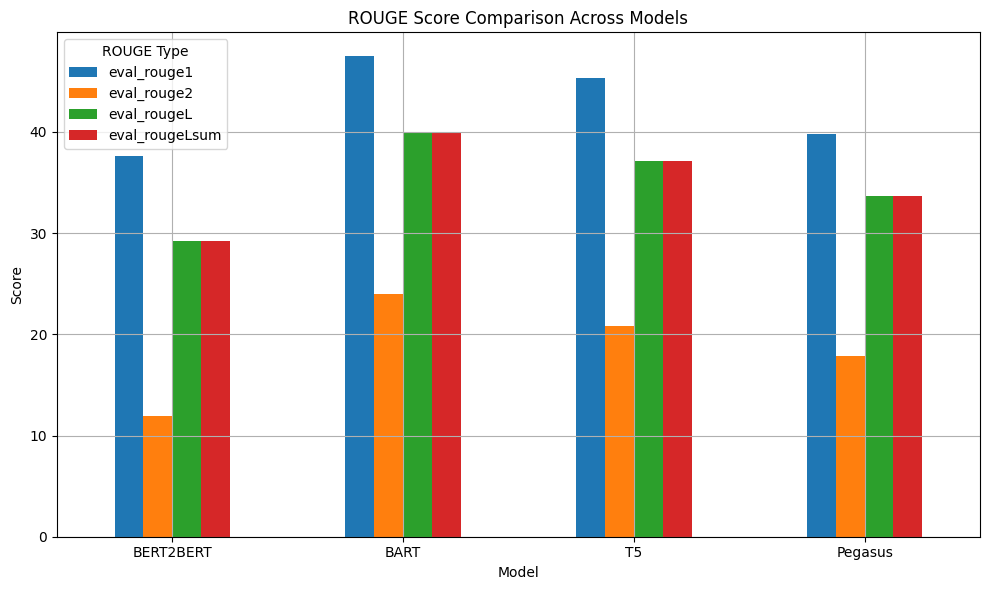

In [97]:
# Plot all rouge scores from each dataset onto one graph for easy to display
rouge_df = pd.DataFrame({
    'BERT2BERT': bert_rouge,
    'BART': bart_rouge,
    'T5': t5_rouge,
    'Pegasus': pegasus_rouge
})


rouge_df.T.plot(kind='bar', figsize=(10,6))
plt.title("ROUGE Score Comparison Across Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="ROUGE Type")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
## Create function to test string against models

In [ ]:
## Display Input, expected results, actual model results for some examples per model

# Visually display 5 random outputs with the expected summary and model summary

### BERT

In [98]:
# Get 5 random samples from the bert_test dataset
small_test_df = test_df.sample(n=5, random_state=None)

In [99]:
# Tokenize dataset
bert_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(bert_tokenizer_load))

# Get predictions from model
outputs = bert_load_trainer.predict(bert_small_test_set)

# Get expected output
dialogues = [ex["dialogue_clean"] for ex in bert_small_test_set]

# Decode predictions
predictions = bert_tokenizer_load.batch_decode(outputs.predictions, skip_special_tokens=True)

# Get expected summary results
references = [ex["summary_clean"] for ex in bert_small_test_set]

# Print all results
for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3950: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained

Decoding: 100%|██████████| 5/5 [00:00<00:00, 322.38it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: nathalie and olaf want to go to tiffany's birthday party on new year's eve.
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's 

### BART

In [100]:
# Tokenize dataset
bart_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(bart_tokenizer_load))

# Get predictions from model
outputs = bart_load_trainer.predict(bart_small_test_set)

# Get original text
dialogues = [ex["dialogue_clean"] for ex in bart_small_test_set]

# Decode outputs
predictions = bart_tokenizer_load.batch_decode(outputs.predictions, skip_special_tokens=True)

# Get expected summaries
references = [ex["summary_clean"] for ex in bart_small_test_set]

# Print results
for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 425.35it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Nathalie and Olafur are going to Soho for New Year's Eve
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's Warsaw ink Javier: 

### Pegasus

In [105]:
pegasus_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(pegasus_tokenizer_load))

outputs = pegasus_load_trainer.predict(pegasus_small_test_set)

dialogues = [ex["dialogue_clean"] for ex in pegasus_small_test_set]
predictions = pegasus_tokenizer_load.batch_decode(outputs.predictions, skip_special_tokens=True)
references = [ex["summary_clean"] for ex in pegasus_small_test_set]

for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 50.28it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Olafur wants to propose to Nathalie on New Year's Eve.
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's Warsaw ink Javier: th

### T5

In [104]:
t5_small_test_set = prepare_dataset(small_test_df, make_tokenize_function(t5_tokenizer_load))

outputs = t5_load_trainer.predict(t5_small_test_set)

dialogues = [ex["dialogue_clean"] for ex in t5_small_test_set]
predictions = t5_tokenizer_load.batch_decode(outputs.predictions, skip_special_tokens=True)
references = [ex["summary_clean"] for ex in t5_small_test_set]

for dialogue, pred, ref in zip(dialogues, predictions, references):
    print(f"\nDialogue: {dialogue}\n\nPredicted: {pred}\nTarget:    {ref}\n")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Decoding: 100%|██████████| 5/5 [00:00<00:00, 56.67it/s]



Dialogue: Olafur: are we doing anything for New Year's Eve? Nathalie: I was thinking about something classy, like opera or sth like that Zoe: how much does it cost? Olafur: opera is not for me Nathalie: so what do you propose? Nathalie: it's 100$ Olafur: I was thinking about partying somewhere Nathalie: partying sounds fun, as long as it will be classy Zoe:  Zoe: Breakfast at Tiffany's party sounds classy Olafur:  Olafur: is it classy enough? Nathalie: :O Nathalie: this club is AMAZING Zoe: whoa Nathalie: we'll going to Soho then Olafur: we just need to hurry up and buy some tickets soon Zoe: sure

Predicted: Nathalie is thinking about something classy for New Year's Eve. She proposes
Target:    Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.


Dialogue: Javier: Hey do you know any tattoo parlors over here with English speaking employees? Judie: Oh there's

# Function to input a chat and have a model summarize.  Expects to have model input (i.e. BERT, BART, Pegasus, T5) - Default is BERT

In [119]:
def summarize_chat(chat_input: str, model_name: str='BERT'):
  model_name = model_name.lower()
  if model_name == 'bart':
    inputs = bart_tokenizer_load(chat_input, return_tensors="pt", truncation=True, padding=True).to(bart_model_load.device)
    generated_ids = bart_model_load.generate(**inputs)
    print(f"BART Summary: {bart_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)}")
    return bart_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)
  elif model_name == 'pegasus':
    inputs = pegasus_tokenizer_load(chat_input, return_tensors="pt", truncation=True, padding=True).to(pegasus_model_load.device)
    generated_ids = pegasus_model_load.generate(**inputs)
    print(f"Pegasus Summary: {pegasus_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)}")
    return pegasus_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)
  elif model_name =='t5':
    inputs = t5_tokenizer_load(chat_input, return_tensors="pt", truncation=True, padding=True).to(t5_model_load.device)
    generated_ids = t5_model_load.generate(**inputs)
    print(f"T5 Summary: {t5_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)}")
    return t5_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)
  else:
    inputs = bert_tokenizer_load(chat_input, return_tensors="pt", truncation=True, padding=True).to(bert_model_load.device)
    generated_ids = bert_model_load.generate(**inputs)
    print(f"BERT Summary: {bert_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)}")
    return bert_tokenizer_load.decode(generated_ids[0], skip_special_tokens=True)

In [124]:
chat = "Andrew: I have to go to the bathroom.  James: There is one on the 5th floor.  Andrew: Ok thanks I will use that one"
chat2 = "Andy: I wonder how long it will take to get a job.  CJ: 87% of people get a job in 6 months.  Andrew: I don't want to wait 6 months.  CJ: Most people find a job a lot sooner"

result_bert = summarize_chat(chat, 'BERT')
result_bart = summarize_chat(chat, 'Bart')
result_pegasus = summarize_chat(chat, 'pEGasus')
result_t5 = summarize_chat(chat, 'T5')
print("\n")
result_bert2 = summarize_chat(chat2, 'BERT')
result_bart2 = summarize_chat(chat2, 'Bart')
result_pegasus2 = summarize_chat(chat2, 'pEGasus')
result_t52 = summarize_chat(chat2, 'T5')

BERT Summary: james will go to the bathroom in 5 minutes.
BART Summary: Andrew has to go to the bathroom on the 5th floor. James will use the bathroom
Pegasus Summary: Andrew has to go to the bathroom.
T5 Summary: Andrew has to go to the bathroom. James has a bathroom on the 5th floor. Andrew


BERT Summary: andy is looking for a job as a worker.
BART Summary: Andy and CJ are wondering how long it will take to get a job.
Pegasus Summary: Andy and CJ want to know how long it will take to get a job.
T5 Summary: CJ says 87% of people get a job in 6 months. Andrew wants to wait 6
